# Network of LIF neurons (Brunel)

In [2]:
#sourcecode

import brian2 as b2
from brian2 import NeuronGroup, Synapses, PoissonInput
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
from random import sample
from neurodynex3.tools import plot_tools
from numpy import random
import matplotlib.pyplot as plt


# Default parameters of a single LIF neuron
V_REST = 0. * b2.mV
V_RESET = +10. * b2.mV
FIRING_THRESHOLD = +20. * b2.mV
MEMBRANE_TIME_SCALE = 20. * b2.ms
ABSOLUTE_REFRACTORY_PERIOD = 2.0 * b2.ms
# Default parameters of the network
SYNAPTIC_WEIGHT_W0 = 0.1 * b2.mV
# note: w_ee = w_ei = w0 and w_ie=w_ii = -g*w0
RELATIVE_INHIBITORY_STRENGTH_G = 4.  # balanced
CONNECTION_PROBABILITY_EPSILON = 0.1
SYNAPTIC_DELAY = 1.5 * b2.ms
POISSON_INPUT_RATE = 13. * b2.Hz
N_POISSON_INPUT = 1000

b2.defaultclock.dt = 0.05 * b2.ms

def simulate_brunel_network(
        N_Excit=5000,
        N_Inhib=None,
        N_extern=N_POISSON_INPUT,
        connection_probability=CONNECTION_PROBABILITY_EPSILON,
        w0=SYNAPTIC_WEIGHT_W0,
        g=RELATIVE_INHIBITORY_STRENGTH_G,
        synaptic_delay=SYNAPTIC_DELAY,
        poisson_input_rate=POISSON_INPUT_RATE,
        w_external=None,
        v_rest=V_REST,
        v_reset=V_RESET,
        firing_threshold=FIRING_THRESHOLD,
        membrane_time_scale=MEMBRANE_TIME_SCALE,
        abs_refractory_period=ABSOLUTE_REFRACTORY_PERIOD,
        monitored_subset_size=100,
        random_vm_init=False,
        sim_time=100.*b2.ms):
    """
    Fully parametrized implementation of a sparsely connected network of LIF neurons (Brunel 2000)

    Args:
        N_Excit (int): Size of the excitatory popluation
        N_Inhib (int): optional. Size of the inhibitory population.
            If not set (=None), N_Inhib is set to N_excit/4.
        N_extern (int): optional. Number of presynaptic excitatory poisson neurons. Note: if set to a value,
            this number does NOT depend on N_Excit and NOT depend on connection_probability (this is different
            from the book and paper. Only if N_extern is set to 'None', then N_extern is computed as
            N_Excit*connection_probability.
        connection_probability (float): probability to connect to any of the (N_Excit+N_Inhib) neurons
            CE = connection_probability*N_Excit
            CI = connection_probability*N_Inhib
            Cexternal = N_extern
        w0 (float): Synaptic strength J
        g (float): relative importance of inhibition. J_exc = w0. J_inhib = -g*w0
        synaptic_delay (Quantity): Delay between presynaptic spike and postsynaptic increase of v_m
        poisson_input_rate (Quantity): Poisson rate of the external population
        w_external (float): optional. Synaptic weight of the excitatory external poisson neurons onto all
            neurons in the network. Default is None, in that case w_external is set to w0, which is the
            standard value in the book and in the paper Brunel2000.
            The purpose of this parameter is to see the effect of external input in the
            absence of network feedback(setting w0 to 0mV and w_external>0).
        v_rest (Quantity): Resting potential
        v_reset (Quantity): Reset potential
        firing_threshold (Quantity): Spike threshold
        membrane_time_scale (Quantity): tau_m
        abs_refractory_period (Quantity): absolute refractory period, tau_ref
        monitored_subset_size (int): nr of neurons for which a VoltageMonitor is recording Vm
        random_vm_init (bool): if true, the membrane voltage of each neuron is initialized with a
            random value drawn from Uniform(v_rest, firing_threshold)
        sim_time (Quantity): Simulation time

    Returns:
        (rate_monitor, spike_monitor, voltage_monitor, idx_monitored_neurons)
        PopulationRateMonitor: Rate Monitor
        SpikeMonitor: SpikeMonitor for ALL (N_Excit+N_Inhib) neurons
        StateMonitor: membrane voltage for a selected subset of neurons
        list: index of monitored neurons. length = monitored_subset_size
    """
    if N_Inhib is None:
        N_Inhib = int(N_Excit/4)
    if N_extern is None:
        N_extern = int(N_Excit*connection_probability)
    if w_external is None:
        w_external = w0

    J_excit = w0
    J_inhib = -g*w0

    lif_dynamics = """
    dv/dt = -(v-v_rest) / membrane_time_scale : volt (unless refractory)"""

    network = NeuronGroup(
        N_Excit+N_Inhib, model=lif_dynamics,
        threshold="v>firing_threshold", reset="v=v_reset", refractory=abs_refractory_period,
        method="linear")
    if random_vm_init:
        network.v = random.uniform(v_rest/b2.mV, high=firing_threshold/b2.mV, size=(N_Excit+N_Inhib))*b2.mV
    else:
        network.v = v_rest
    excitatory_population = network[:N_Excit]
    inhibitory_population = network[N_Excit:]

    exc_synapses = Synapses(excitatory_population, target=network, on_pre="v += J_excit", delay=synaptic_delay)
    exc_synapses.connect(p=connection_probability)

    inhib_synapses = Synapses(inhibitory_population, target=network, on_pre="v += J_inhib", delay=synaptic_delay)
    inhib_synapses.connect(p=connection_probability)

    external_poisson_input = PoissonInput(target=network, target_var="v", N=N_extern,
                                          rate=poisson_input_rate, weight=w_external)

    # collect data of a subset of neurons:
    monitored_subset_size = min(monitored_subset_size, (N_Excit+N_Inhib))
    idx_monitored_neurons = sample(range(N_Excit+N_Inhib), monitored_subset_size)
    rate_monitor = PopulationRateMonitor(network)
    # record= some_list is not supported? :-(
    spike_monitor = SpikeMonitor(network, record=idx_monitored_neurons)
    voltage_monitor = StateMonitor(network, "v", record=idx_monitored_neurons)

    b2.run(sim_time)
    return rate_monitor, spike_monitor, voltage_monitor, idx_monitored_neurons

# 10.1. Exercise: model parameters and threshold rate


In this exercise we study a well known network of sparsely connected Leaky-Integrate-And-Fire neurons (https://link-springer-com.tudelft.idm.oclc.org/article/10.1023/A:1008925309027)

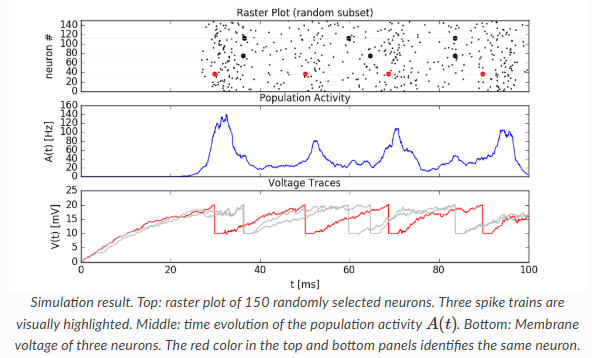

(<Figure size 1000x400 with 3 Axes>,
 <Axes: title={'center': 'Raster Plot'}, ylabel='neuron #'>,
 <Axes: title={'center': 'Population Activity'}, ylabel='A(t) [Hz]'>,
 <Axes: title={'center': 'Voltage Traces'}, xlabel='t [ms]', ylabel='V(t) [mV]'>)

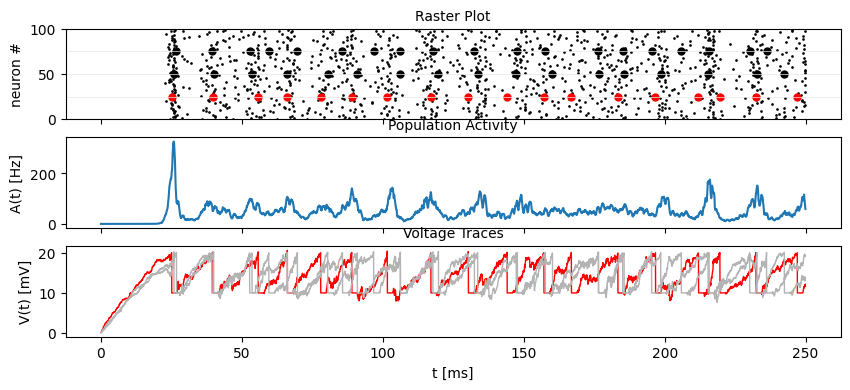

In [3]:
%matplotlib inline
from neurodynex3.brunel_model import LIF_spiking_network
from neurodynex3.tools import plot_tools
import brian2 as b2

rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = LIF_spiking_network.simulate_brunel_network(sim_time=250. * b2.ms)
plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=0.*b2.ms)

In [4]:
# Default parameters of a single LIF neuron:
V_REST = 0. * b2.mV
V_RESET = +10. * b2.mV
FIRING_THRESHOLD = +20. * b2.mV
MEMBRANE_TIME_SCALE = 20. * b2.ms
ABSOLUTE_REFRACTORY_PERIOD = 2.0 * b2.ms

# Default parameters of the network
SYNAPTIC_WEIGHT_W0 = 0.1 * b2.mV  # note: w_ee=w_ie = w0 and = w_ei=w_ii = -g*w0
RELATIVE_INHIBITORY_STRENGTH_G = 4.  # balanced
CONNECTION_PROBABILITY_EPSILON = 0.1
SYNAPTIC_DELAY = 1.5 * b2.ms
POISSON_INPUT_RATE = 12. * b2.Hz
N_POISSON_INPUT = 1000

- Ne = size of excitatory population
- NI = size of inhibitory population
- Ce = probability to connect to any of the excitatory neurons
- Ci = probability to connect to any of the inhibitory neurons
- wee, wei, wie, wii = synaptic strengths

The weight here has units of voltage and directly gives the amplitude of the voltage jump. 


In [5]:
vthresh = (LIF_spiking_network.FIRING_THRESHOLD)/(LIF_spiking_network.N_POISSON_INPUT*LIF_spiking_network.SYNAPTIC_WEIGHT_W0*LIF_spiking_network.MEMBRANE_TIME_SCALE)
print('vthresh is', vthresh)

'''
The frequency νthreshold is the poisson rate of the external population 
sufficient to drive the neurons in the network to the firing threshold.
'''


vthresh is 10. Hz


'\nThe frequency νthreshold is the poisson rate of the external population \nsufficient to drive the neurons in the network to the firing threshold.\n'

*Refering to Fig. 13.7, left panel, what is the meaning of the value 1 on the y-axis (Input). What is the horizontal dashed line designating? How is this related to utrh?*

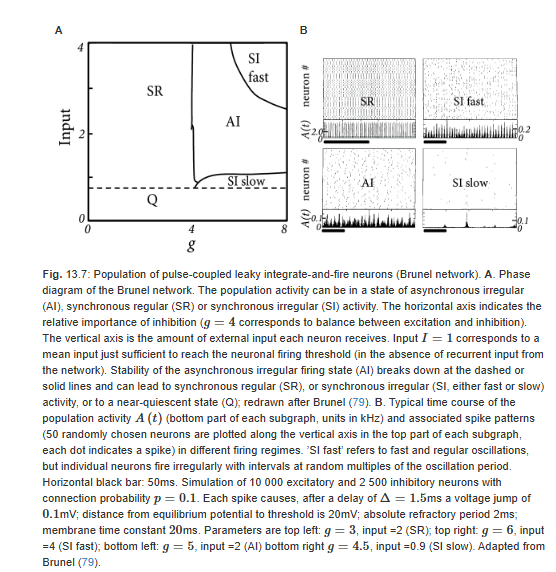



Input I=1 corresponds to a mean input just sufficient to reach the neuronal firing threshold (in the absence of recurrent input from the network).
Stability of the asynchronous irregular firing state (AI) breaks down at the dashed or solid lines and can lead to synchronous regular (SR), or synchronous irregular (SI, either fast or slow) activity, or to a near-quiescent state (Q). At input = 1, neurons would reach uthr independently, but network dynamics further modulate firing patterns.

*Run a simulation for 500ms. Set poisson_input_rate to νthreshold. Plot the network activity in the time interval [0ms, 500ms]. Is the network quiet (Q)?*

vthresh =  10. Hz
64117
6250
Average firing rate is 20.51744


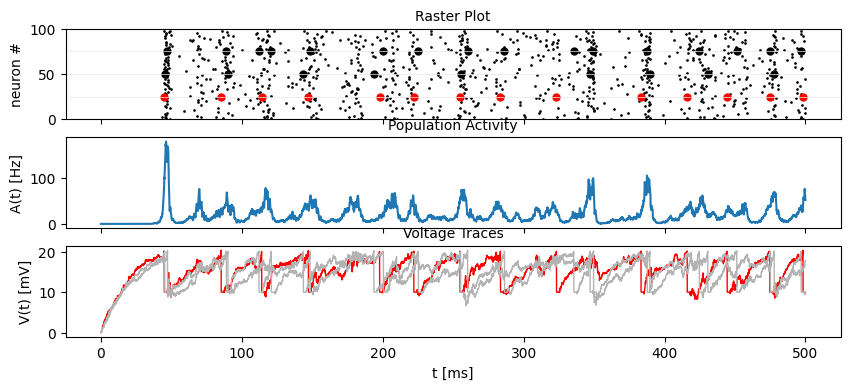

In [6]:
%matplotlib inline
from neurodynex3.brunel_model import LIF_spiking_network
from neurodynex3.tools import plot_tools
import brian2 as b2

vthresh = (LIF_spiking_network.FIRING_THRESHOLD)/(LIF_spiking_network.N_POISSON_INPUT*LIF_spiking_network.SYNAPTIC_WEIGHT_W0*LIF_spiking_network.MEMBRANE_TIME_SCALE)
print("vthresh = ", vthresh)

rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = LIF_spiking_network.simulate_brunel_network(sim_time=500. * b2.ms, poisson_input_rate = vthresh)
plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=0.*b2.ms)

# Network is not quiet, we clearly see repetitive spiking. 

spikenum = spike_monitor.num_spikes 
print(spikenum)
networkN = spike_monitor.source.N
print(networkN)

#calculate average firing rate
avg_firing_rate = spikenum / (networkN*0.5)
print("Average firing rate is", avg_firing_rate)

Obviously, no, the network is not quiet when we stimulate at vthresohold. The frequency νthreshold is the poisson rate of the external population sufficient to drive the neurons in the network to the firing threshold. 

# 10.2. Exercise: Population activity

The network of spiking LIF-neurons shows characteristic population activities. In this exercise we investigate the asynchronous irregular (AI), synchronous regular (SR), fast synchronous irregular (SI-fast) and slow synchronous irregular (SI-slow) activity types.

Define a network of 6000 excitatory and 1500 inhibitory neurons. Find the appropriate parameters and simulate the network in the regimes AI, SR, SI-fast and SI-slow. For each of the four configurations, plot the network activity and compute the average firing rate. Run each simulation for at least 1000ms and plot two figures for each simulation: one showing the complete simulation time and one showing only the last ~50ms.

vthresh is  10. Hz
Average population activity over the last 200 ms: 8.72 Hz


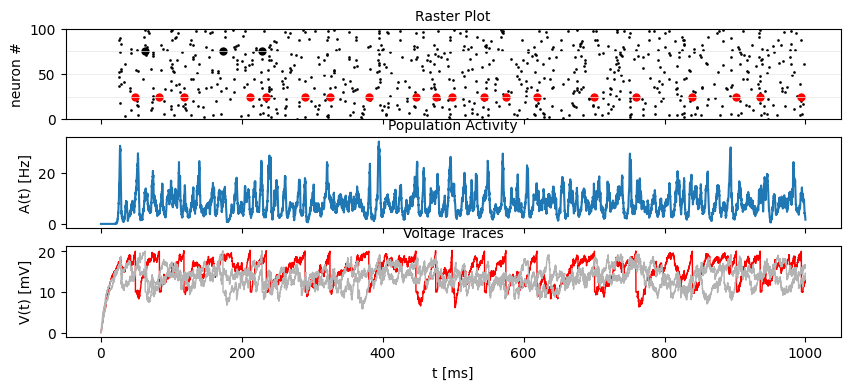

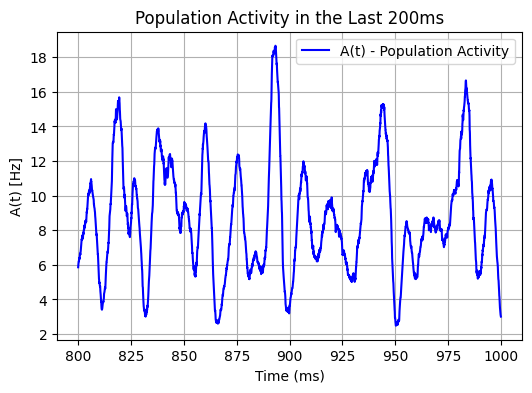

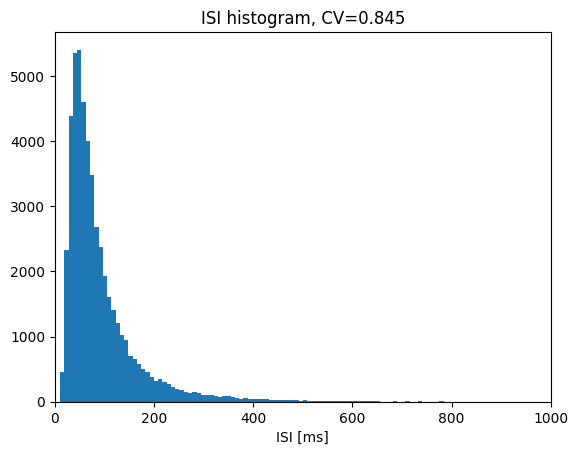

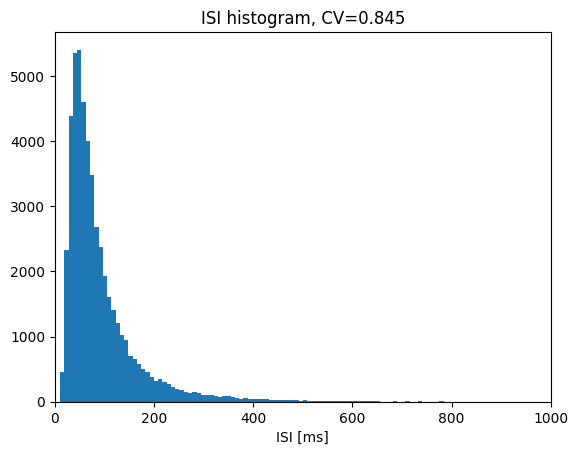

In [7]:
# Asynchronus irregular (AI)

%matplotlib inline
from neurodynex3.brunel_model import LIF_spiking_network
from neurodynex3.tools import plot_tools, spike_tools
import brian2 as b2
import numpy as np
import matplotlib.pyplot as plt

vthresh = (LIF_spiking_network.FIRING_THRESHOLD) / (LIF_spiking_network.N_POISSON_INPUT * 
                                                     LIF_spiking_network.SYNAPTIC_WEIGHT_W0 * 
                                                     LIF_spiking_network.MEMBRANE_TIME_SCALE)
print("vthresh is ", vthresh)

v_ext = 12.0 * b2.Hz  
g_inhib = 7.0         
delay = 1.5 * b2.ms   

rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = LIF_spiking_network.simulate_brunel_network(
    sim_time=1000. * b2.ms, N_Excit=6000, N_Inhib=1500, poisson_input_rate=v_ext, g=g_inhib, synaptic_delay=delay)

plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=0.*b2.ms)

times = rate_monitor.t / b2.ms  
rates = rate_monitor.smooth_rate(window="flat", width=5.0 * b2.ms) / b2.Hz  

time_window_start = 800  
time_window_end = 1000   
mask = (times >= time_window_start) & (times <= time_window_end)

avg_firing_rate_last_200ms = np.mean(rates[mask])
print(f"Average population activity over the last 200 ms: {avg_firing_rate_last_200ms:.2f} Hz")

plt.figure(figsize=(6,4))
plt.plot(times[mask], rates[mask], label="A(t) - Population Activity", color='blue')
plt.xlabel("Time (ms)")
plt.ylabel("A(t) [Hz]")
plt.title("Population Activity in the Last 200ms")
plt.legend()
plt.grid()
plt.show()

spike_stats = spike_tools.get_spike_train_stats(spike_monitor, window_t_min= 100 * b2.ms)
plot_tools.plot_ISI_distribution(spike_stats, hist_nr_bins=100, xlim_max_ISI= 1000 * b2.ms)


In [8]:
'''
# old code

%matplotlib inline
from neurodynex3.brunel_model import LIF_spiking_network
from neurodynex3.tools import plot_tools, spike_tools 
import brian2 as b2

vthresh = (LIF_spiking_network.FIRING_THRESHOLD)/(LIF_spiking_network.N_POISSON_INPUT*LIF_spiking_network.SYNAPTIC_WEIGHT_W0*LIF_spiking_network.MEMBRANE_TIME_SCALE)
print("vthresh is ", vthresh)

v_ext = 12.0 * b2.Hz
g_inhib = 7.0
delay = 1.5 * b2.ms

rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = LIF_spiking_network.simulate_brunel_network(
    sim_time=1000. * b2.ms, N_Excit = 6000, N_Inhib = 1500, poisson_input_rate = v_ext, g = g_inhib, synaptic_delay = delay)

plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=0.*b2.ms)
plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=950*b2.ms)
 

spikenum = spike_monitor.num_spikes 
#print(spikenum)
networkN = spike_monitor.source.N
#print(networkN)

#calculate average firing rate
avg_firing_rate = spikenum / (networkN*0.5)
print("Average firing rate is", avg_firing_rate)

spike_stats = spike_tools.get_spike_train_stats(spike_monitor, window_t_min= 100 *b2.ms)
plot_tools.plot_ISI_distribution(spike_stats, hist_nr_bins=100, xlim_max_ISI= 1000 *b2.ms)
'''

'\n# old code\n\n%matplotlib inline\nfrom neurodynex3.brunel_model import LIF_spiking_network\nfrom neurodynex3.tools import plot_tools, spike_tools \nimport brian2 as b2\n\nvthresh = (LIF_spiking_network.FIRING_THRESHOLD)/(LIF_spiking_network.N_POISSON_INPUT*LIF_spiking_network.SYNAPTIC_WEIGHT_W0*LIF_spiking_network.MEMBRANE_TIME_SCALE)\nprint("vthresh is ", vthresh)\n\nv_ext = 12.0 * b2.Hz\ng_inhib = 7.0\ndelay = 1.5 * b2.ms\n\nrate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = LIF_spiking_network.simulate_brunel_network(\n    sim_time=1000. * b2.ms, N_Excit = 6000, N_Inhib = 1500, poisson_input_rate = v_ext, g = g_inhib, synaptic_delay = delay)\n\nplot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=0.*b2.ms)\nplot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=950*b2.ms)\n \n\nspikenum = spike_monitor.num_spikes \n#pri

vthresh is  10. Hz
Average population activity over the last 200 ms: 223.46 Hz


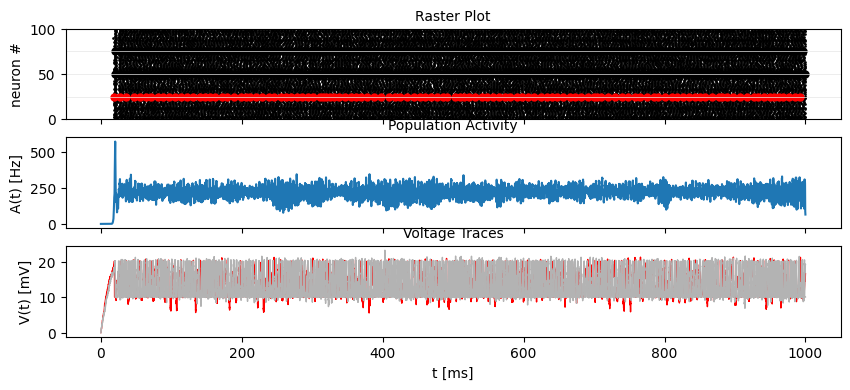

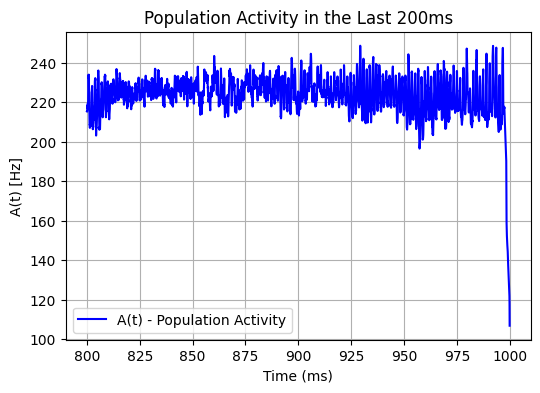

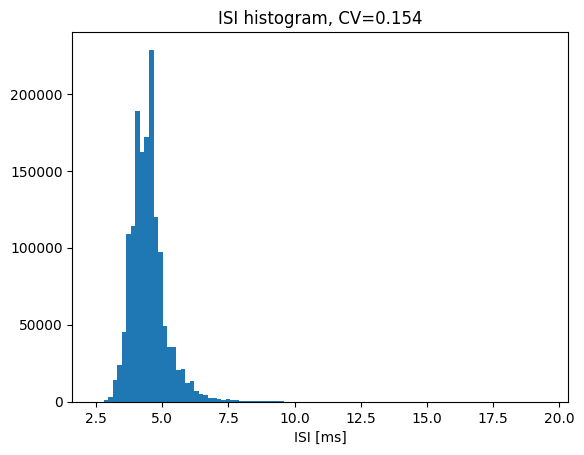

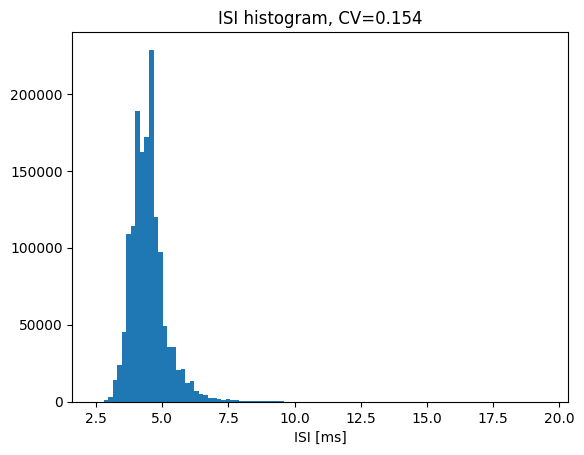

In [9]:
# Synchronous regular (SR)

%matplotlib inline
from neurodynex3.brunel_model import LIF_spiking_network
from neurodynex3.tools import plot_tools, spike_tools
import brian2 as b2
import numpy as np
import matplotlib.pyplot as plt

vthresh = (LIF_spiking_network.FIRING_THRESHOLD) / (LIF_spiking_network.N_POISSON_INPUT * 
                                                     LIF_spiking_network.SYNAPTIC_WEIGHT_W0 * 
                                                     LIF_spiking_network.MEMBRANE_TIME_SCALE)
print("vthresh is ", vthresh)

v_ext = 15.0 * b2.Hz
g_inhib = 3.0
delay = 1.5 * b2.ms

rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = LIF_spiking_network.simulate_brunel_network(
    sim_time=1000. * b2.ms, N_Excit=6000, N_Inhib=1500, poisson_input_rate=v_ext, g=g_inhib, synaptic_delay=delay)

plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=0.*b2.ms)

times = rate_monitor.t / b2.ms  
rates = rate_monitor.smooth_rate(window="flat", width=5.0 * b2.ms) / b2.Hz  

time_window_start = 800  
time_window_end = 1000   
mask = (times >= time_window_start) & (times <= time_window_end)

avg_firing_rate_last_200ms = np.mean(rates[mask])
print(f"Average population activity over the last 200 ms: {avg_firing_rate_last_200ms:.2f} Hz")

plt.figure(figsize=(6,4))
plt.plot(times[mask], rates[mask], label="A(t) - Population Activity", color='blue')
plt.xlabel("Time (ms)")
plt.ylabel("A(t) [Hz]")
plt.title("Population Activity in the Last 200ms")
plt.legend()
plt.grid()
plt.show()

spike_stats = spike_tools.get_spike_train_stats(spike_monitor, window_t_min= 100 * b2.ms)
plot_tools.plot_ISI_distribution(spike_stats, hist_nr_bins=100)


vthresh is  10. Hz
Average population activity over the last 200 ms: 13.89 Hz


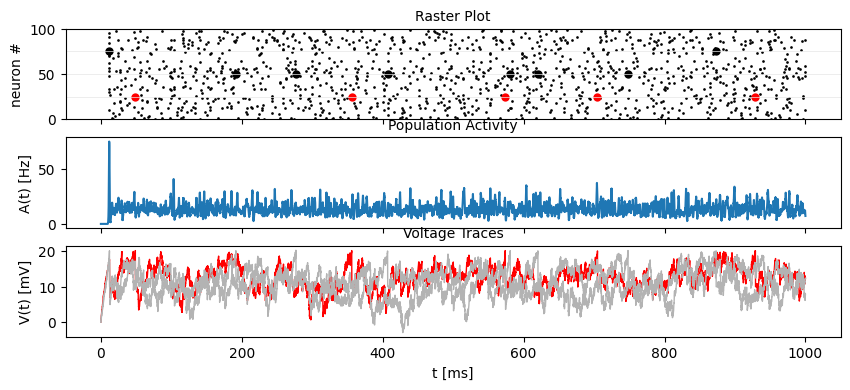

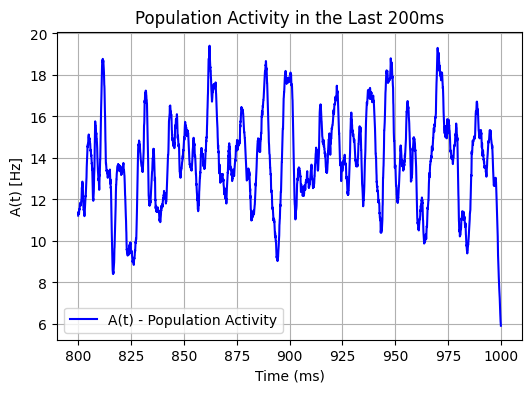

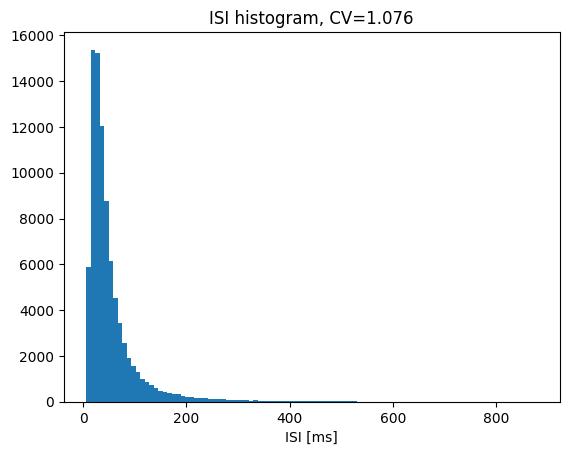

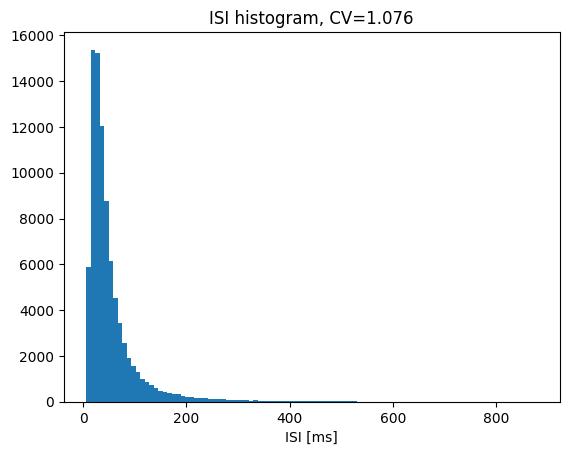

In [10]:
# Synchronous irregular fast

%matplotlib inline
from neurodynex3.brunel_model import LIF_spiking_network
from neurodynex3.tools import plot_tools, spike_tools
import brian2 as b2
import numpy as np
import matplotlib.pyplot as plt

vthresh = (LIF_spiking_network.FIRING_THRESHOLD) / (LIF_spiking_network.N_POISSON_INPUT * 
                                                     LIF_spiking_network.SYNAPTIC_WEIGHT_W0 * 
                                                     LIF_spiking_network.MEMBRANE_TIME_SCALE)
print("vthresh is ", vthresh)

v_ext = 20.0 * b2.Hz
g_inhib = 10.0
delay = .5 * b2.ms

rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = LIF_spiking_network.simulate_brunel_network(
    sim_time=1000. * b2.ms, N_Excit=6000, N_Inhib=1500, poisson_input_rate=v_ext, g=g_inhib, synaptic_delay=delay)

plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=0.*b2.ms)

times = rate_monitor.t / b2.ms  
rates = rate_monitor.smooth_rate(window="flat", width=5.0 * b2.ms) / b2.Hz  

time_window_start = 800  
time_window_end = 1000   
mask = (times >= time_window_start) & (times <= time_window_end)

avg_firing_rate_last_200ms = np.mean(rates[mask])
print(f"Average population activity over the last 200 ms: {avg_firing_rate_last_200ms:.2f} Hz")

plt.figure(figsize=(6,4))
plt.plot(times[mask], rates[mask], label="A(t) - Population Activity", color='blue')
plt.xlabel("Time (ms)")
plt.ylabel("A(t) [Hz]")
plt.title("Population Activity in the Last 200ms")
plt.legend()
plt.grid()
plt.show()

spike_stats = spike_tools.get_spike_train_stats(spike_monitor, window_t_min= 100 * b2.ms)
plot_tools.plot_ISI_distribution(spike_stats, hist_nr_bins=100)

vthresh is  10. Hz
Average population activity over the last 200 ms: 13.45 Hz


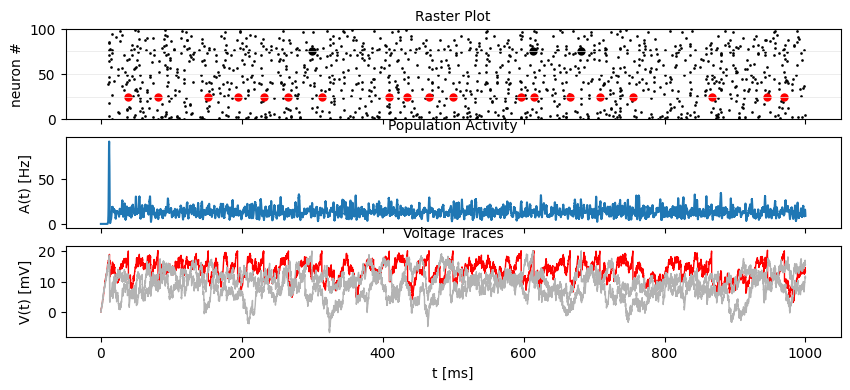

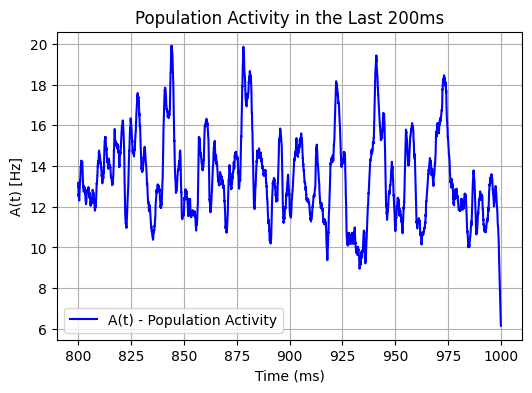

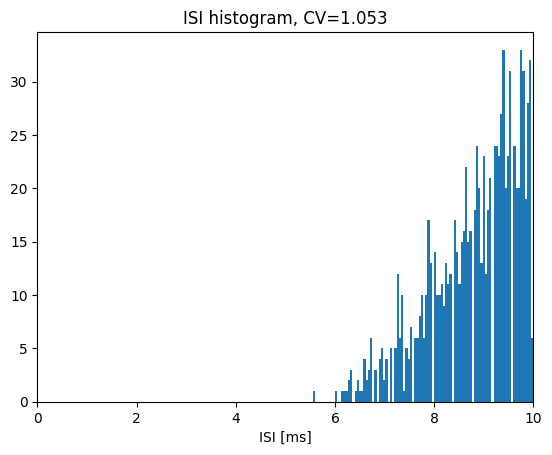

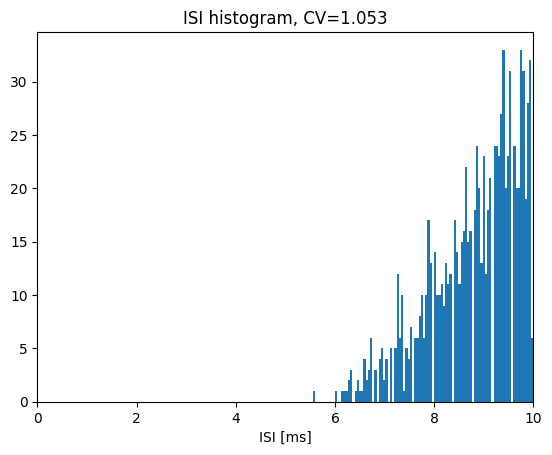

In [11]:
# Synchronous irregular slow

%matplotlib inline
from neurodynex3.brunel_model import LIF_spiking_network
from neurodynex3.tools import plot_tools, spike_tools
import brian2 as b2
import numpy as np
import matplotlib.pyplot as plt

vthresh = (LIF_spiking_network.FIRING_THRESHOLD) / (LIF_spiking_network.N_POISSON_INPUT * 
                                                     LIF_spiking_network.SYNAPTIC_WEIGHT_W0 * 
                                                     LIF_spiking_network.MEMBRANE_TIME_SCALE)
print("vthresh is ", vthresh)

v_ext = 20.0 * b2.Hz
g_inhib = 10.0
delay = .5 * b2.ms

rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = LIF_spiking_network.simulate_brunel_network(
    sim_time=1000. * b2.ms, N_Excit=6000, N_Inhib=1500, poisson_input_rate=v_ext, g=g_inhib, synaptic_delay=delay)

plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=0.*b2.ms)

times = rate_monitor.t / b2.ms  
rates = rate_monitor.smooth_rate(window="flat", width=5.0 * b2.ms) / b2.Hz  

time_window_start = 800  
time_window_end = 1000   
mask = (times >= time_window_start) & (times <= time_window_end)

avg_firing_rate_last_200ms = np.mean(rates[mask])
print(f"Average population activity over the last 200 ms: {avg_firing_rate_last_200ms:.2f} Hz")

plt.figure(figsize=(6,4))
plt.plot(times[mask], rates[mask], label="A(t) - Population Activity", color='blue')
plt.xlabel("Time (ms)")
plt.ylabel("A(t) [Hz]")
plt.title("Population Activity in the Last 200ms")
plt.legend()
plt.grid()
plt.show()

spike_stats = spike_tools.get_spike_train_stats(spike_monitor, window_t_min= 100 * b2.ms)
plot_tools.plot_ISI_distribution(spike_stats, hist_nr_bins=100, xlim_max_ISI= 10 * b2.ms)


The estimation of interspike interval (ISI) distributions from experimental data is a common method to study neuronal variability given a certain stationary input. In a typical experiment, the spike train of a single neuron (e.g., a neuron in visual cortex) is recorded while driven by a constant stimulus. The stimulus might be an external input applied to the system (e.g., a visual contrast grating moving at constant speed); or it may be an intracellularly applied constant driving current. For a sufficiently long spike train, the histogram provides a good estimate of the ISI distribution

Interspike interval distributions P0(s) derived from a spike train under stationary conditions can be broad or sharply peaked. To quantify the width of the interval distribution, we evaluate the coefficient of variation (CV); defined as the ratio of the standard deviation and the mean.

The CV of a Poisson neuron is 1. 


The coefficient of variation (CV) is a measure of the variability of a distribution relative to its mean. It is commonly used in neuroscience to quantify the irregularity of interspike intervals (ISIs) in neuronal activity. A CV value provides insights into whether a neuron's firing pattern is more regular or irregular.

- CV = 0 --> constant ISI, regular periodic firing
- CV = 1 --> exponential distribution, irregular asynchronous firing
- CV > 1 --> ISIs are highly variable, bursty or oscillatory firing (very asynchronous)



# 10.3. Exercise: Emergence of Synchronization

The different regimes emerge from the recurrence and the relative strength of inhibition g. In the absence of recurrent excitatory connections, the network would approach a constant mean activity A(t).

vthresh is 10. Hz
Average population activity over the last 200 ms: 389.66 Hz


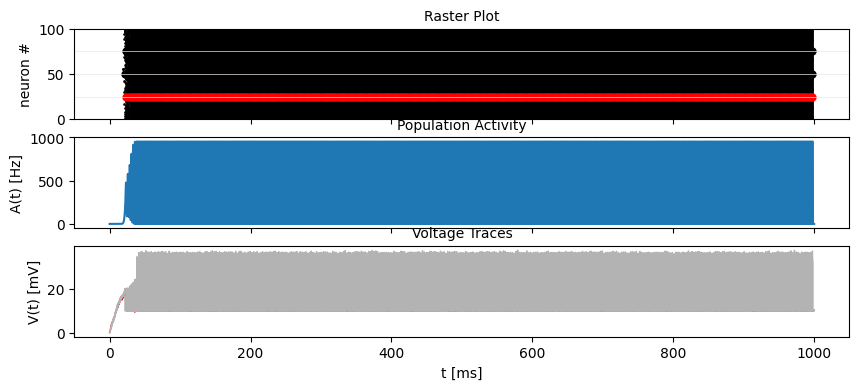

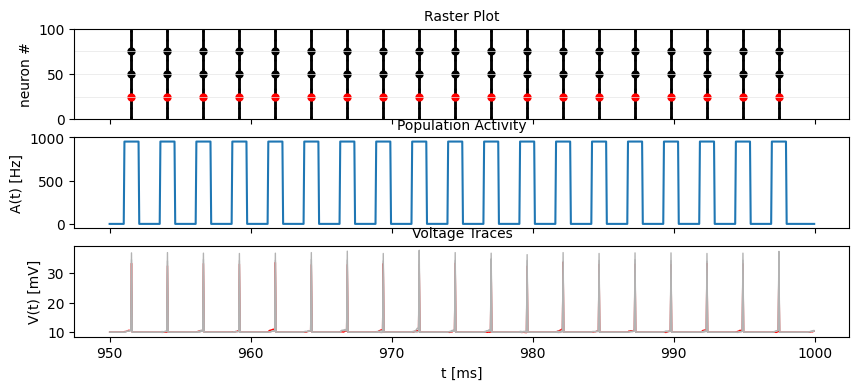

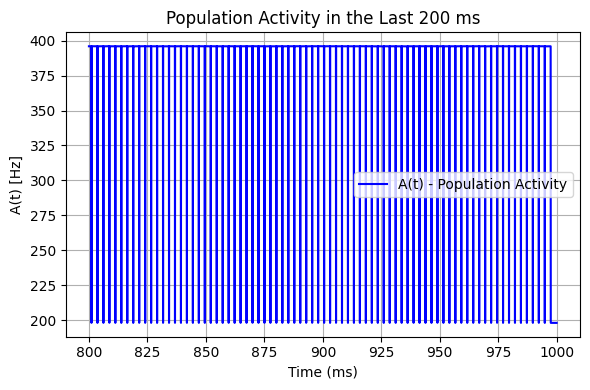

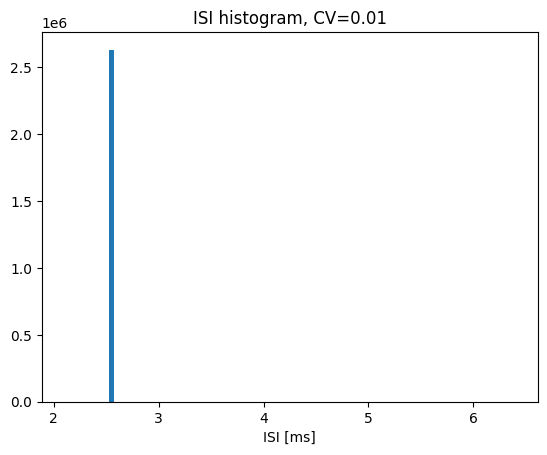

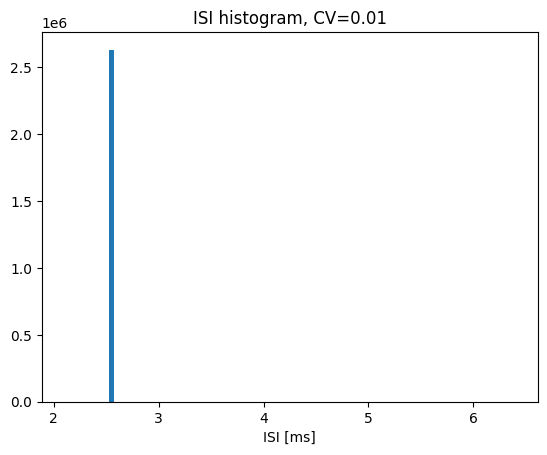

In [12]:
# 10.3.1 Simulate a Brunel Network: 6000 excitatory & 1500 inhibitory neurons
%matplotlib inline

import brian2 as b2
import numpy as np
import matplotlib.pyplot as plt

from neurodynex3.brunel_model import LIF_spiking_network
from neurodynex3.tools import plot_tools, spike_tools

poisson_rate = 14. * b2.Hz
g_inhib = 2.5
delay = 2.5 * b2.ms

vthresh = (LIF_spiking_network.FIRING_THRESHOLD) / (
    LIF_spiking_network.N_POISSON_INPUT *
    LIF_spiking_network.SYNAPTIC_WEIGHT_W0 *
    LIF_spiking_network.MEMBRANE_TIME_SCALE
)
print("vthresh is", vthresh)

rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = LIF_spiking_network.simulate_brunel_network(
    sim_time=1000. * b2.ms,
    N_Excit=6000,
    N_Inhib=1500,
    poisson_input_rate=poisson_rate,
    g=g_inhib,
    synaptic_delay=delay
)

plot_tools.plot_network_activity(
    rate_monitor, spike_monitor, voltage_monitor,
    spike_train_idx_list=monitored_spike_idx, t_min=0.*b2.ms
)
plot_tools.plot_network_activity(
    rate_monitor, spike_monitor, voltage_monitor,
    spike_train_idx_list=monitored_spike_idx, t_min=950.*b2.ms
)

times = rate_monitor.t / b2.ms
rates = rate_monitor.smooth_rate(window="flat", width=5.0 * b2.ms) / b2.Hz

time_window_start = 800
time_window_end = 1000
mask = (times >= time_window_start) & (times <= time_window_end)

avg_firing_rate_last_200ms = np.mean(rates[mask])
print(f"Average population activity over the last 200 ms: {avg_firing_rate_last_200ms:.2f} Hz")

plt.figure(figsize=(6, 4))
plt.plot(times[mask], rates[mask], label="A(t) - Population Activity", color='blue')
plt.xlabel("Time (ms)")
plt.ylabel("A(t) [Hz]")
plt.title("Population Activity in the Last 200 ms")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

spike_stats = spike_tools.get_spike_train_stats(spike_monitor, window_t_min=100 * b2.ms)
plot_tools.plot_ISI_distribution(spike_stats, hist_nr_bins=100)


This is an extremely synchronous regular network. 

*What would the population activity be if we would have only external input? We can simulate this. Run a simulation of the same network, but disable the recurrent excitatory connections*

vthresh is  10. Hz
Average population activity over the last 200 ms: 54.44 Hz


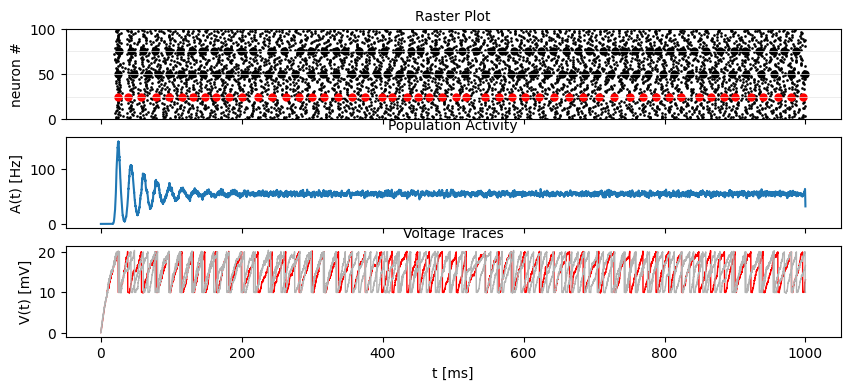

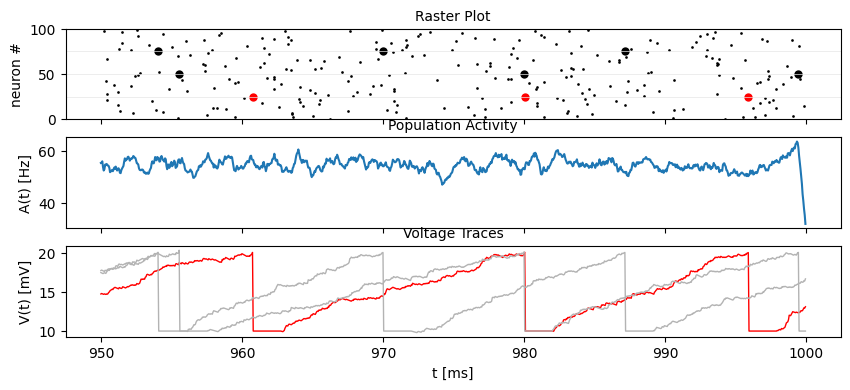

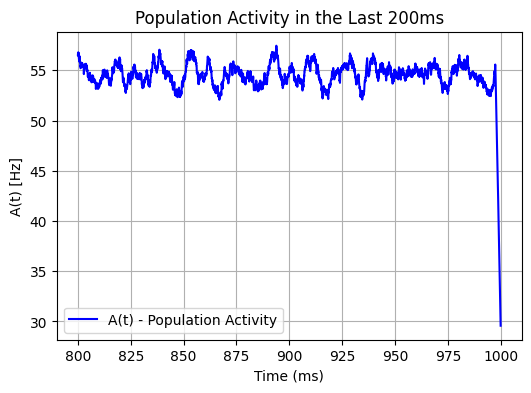

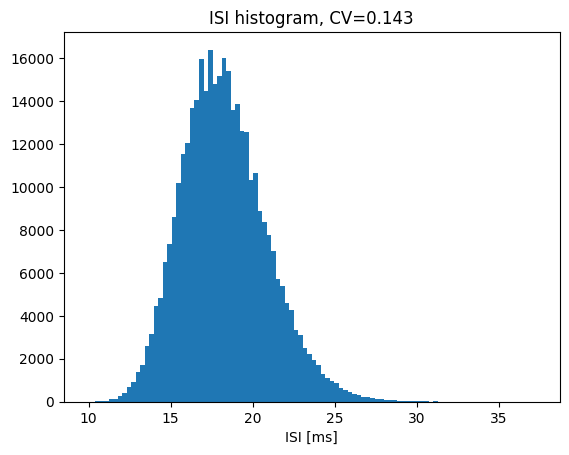

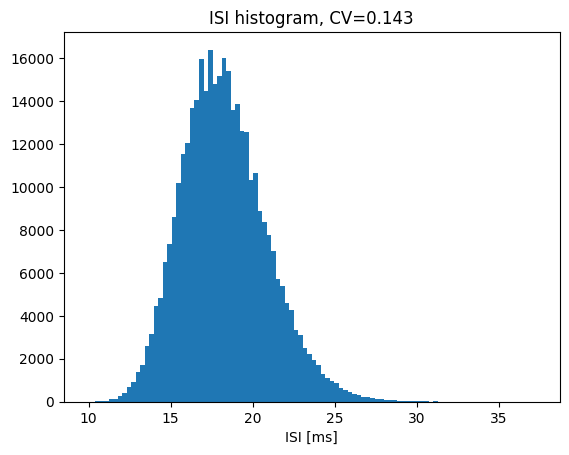

In [13]:
#Run a simulation of the same network, but disable the recurrent excitatory connections
#w0=0.*b2.mV, w_external=LIF_spiking_network.SYNAPTIC_WEIGHT_W0


%matplotlib inline
from neurodynex3.brunel_model import LIF_spiking_network
from neurodynex3.tools import plot_tools, spike_tools
import brian2 as b2
import numpy as np
import matplotlib.pyplot as plt

vthresh = (LIF_spiking_network.FIRING_THRESHOLD) / (LIF_spiking_network.N_POISSON_INPUT * 
                                                     LIF_spiking_network.SYNAPTIC_WEIGHT_W0 * 
                                                     LIF_spiking_network.MEMBRANE_TIME_SCALE)
print("vthresh is ", vthresh)

v_ext = 14.0 * b2.Hz
g_inhib = 2.5
delay = 2.5 * b2.ms

rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = LIF_spiking_network.simulate_brunel_network(
    sim_time=1000. * b2.ms, N_Excit=6000, N_Inhib=1500, poisson_input_rate=v_ext, g=g_inhib, synaptic_delay=delay, w0=0.*b2.mV, w_external=LIF_spiking_network.SYNAPTIC_WEIGHT_W0)

plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=0.*b2.ms)
plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=950*b2.ms)

times = rate_monitor.t / b2.ms  
rates = rate_monitor.smooth_rate(window="flat", width=5.0 * b2.ms) / b2.Hz  

time_window_start = 800  
time_window_end = 1000   
mask = (times >= time_window_start) & (times <= time_window_end)

avg_firing_rate_last_200ms = np.mean(rates[mask])
print(f"Average population activity over the last 200 ms: {avg_firing_rate_last_200ms:.2f} Hz")

plt.figure(figsize=(6,4))
plt.plot(times[mask], rates[mask], label="A(t) - Population Activity", color='blue')
plt.xlabel("Time (ms)")
plt.ylabel("A(t) [Hz]")
plt.title("Population Activity in the Last 200ms")
plt.legend()
plt.grid()
plt.show()

spike_stats = spike_tools.get_spike_train_stats(spike_monitor, window_t_min= 100 * b2.ms)
plot_tools.plot_ISI_distribution(spike_stats, hist_nr_bins=100)







In the non-recurrent network, neurons begin firing at the same time because they start with identical initial conditions (e.g., the same membrane potential).
This artificial synchronization fades over time as individual neurons desynchronize due to the randomness of Poisson input and the lack of recurrent connections to maintain synchrony.

Is the CONNECTED network simply “locked” to this initial synchronization?

To confirm whether synchronization is purely due to initial conditions:
Initialize each neuron with a random membrane potential
#random_vm_init=True

--> Simulation of a network with random v_m initialization. The synchronization of the neurons is not an artifact of shared initial conditions, but emerges over time.

vthresh is  10. Hz
Average firing rate is 626.8544


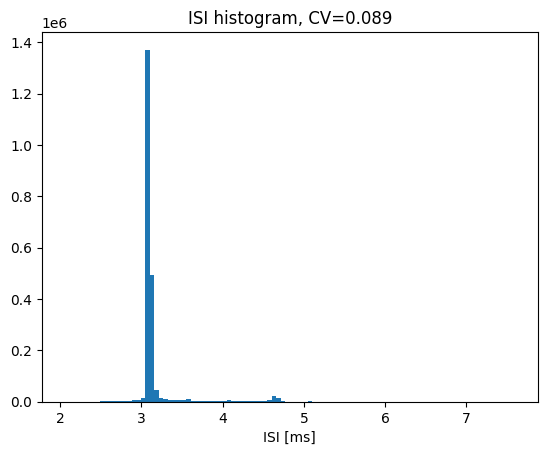

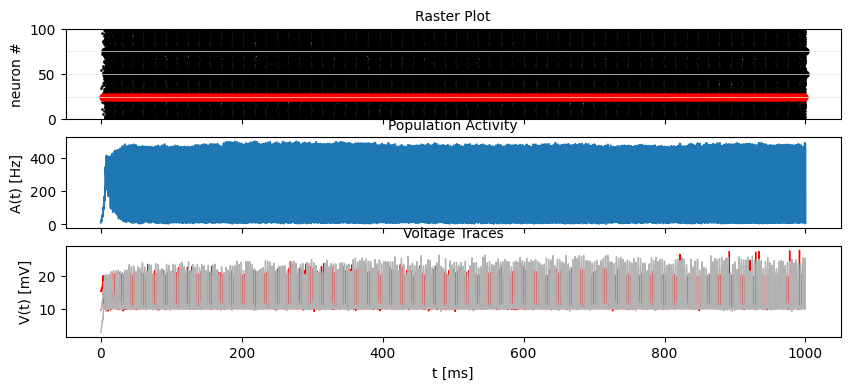

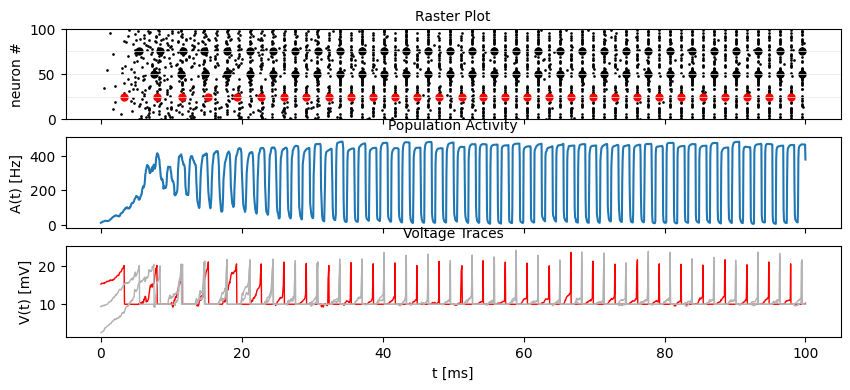

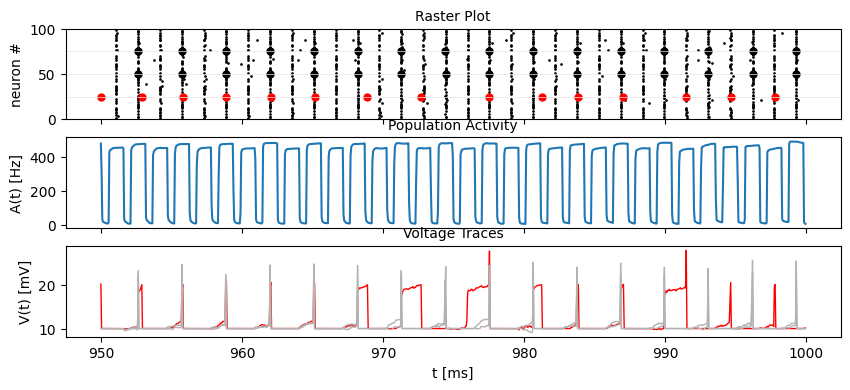

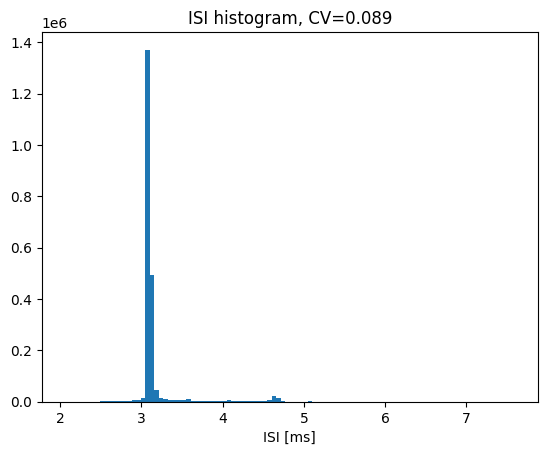

In [14]:
#Run a simulation of the same network, but disable the recurrent excitatory connections
#w0=0.*b2.mV, w_external=LIF_spiking_network.SYNAPTIC_WEIGHT_W0

# 10.3.1

%matplotlib inline
from neurodynex3.brunel_model import LIF_spiking_network
from neurodynex3.tools import plot_tools, spike_tools
import brian2 as b2

vthresh = (LIF_spiking_network.FIRING_THRESHOLD)/(LIF_spiking_network.N_POISSON_INPUT*LIF_spiking_network.SYNAPTIC_WEIGHT_W0*LIF_spiking_network.MEMBRANE_TIME_SCALE)
print("vthresh is ", vthresh)

v_ext = 14.0 * b2.Hz
g_inhib = 2.5
#delay = 2.5 * b2.ms

rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = LIF_spiking_network.simulate_brunel_network(
    sim_time=1000. * b2.ms, N_Excit = 6000, N_Inhib = 1500, poisson_input_rate = v_ext, g = g_inhib, random_vm_init=True)

plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=0.*b2.ms)
plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_max=100*b2.ms)
plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=950*b2.ms)
 

spikenum = spike_monitor.num_spikes 
#print(spikenum)
networkN = spike_monitor.source.N
#print(networkN)

#calculate average firing rate
avg_firing_rate = spikenum / (networkN*0.5)
print("Average firing rate is", avg_firing_rate)

spike_stats = spike_tools.get_spike_train_stats(spike_monitor, window_t_min= 100 *b2.ms)
plot_tools.plot_ISI_distribution(spike_stats, hist_nr_bins=100)



